### SMART WASTE PREDICTION OF BIOFUEL PRODUCTION FROM CORN PRODUCE USING REINFORCEMENT LEARNING ALGORITHM
#### BY

#### OLOTU EMM

#### MATRIC NUMBER: Your matric No

## *Importation of Libraries and Generation of Synthetic Data*

### Imports and Environment Setup

## Step 1. Setting Up the Environment
First, ensure that you have the necessary libraries installed in your Jupyter Notebook. You'll need libraries like numpy, pandas, matplotlib, seaborn, scikit-learn, and stable-baselines3 (for the RL algorithm). You can install these using pip:

#### !pip install numpy pandas matplotlib seaborn scikit-learn stable-baselines3


## Step 2. Generate synthetic data

We'll create synthetic data that simulates the biofuel production process. This data will include features such as *corn_input, processing_time, temperature, enzyme_concentration, and waste_generated*.

In [2]:
import numpy as np
import pandas as pd

# Set a seed for reproducibility
np.random.seed(42)

# Generate synthetic data
data_size = 1000

corn_input = np.random.uniform(100, 200, data_size)  # in kg
processing_time = np.random.uniform(1, 5, data_size)  # in hours
temperature = np.random.uniform(60, 100, data_size)  # in Celsius
enzyme_concentration = np.random.uniform(0.1, 0.5, data_size)  # in g/L

# Waste generated based on a synthetic function (this would be learned in real scenarios)
waste_generated = corn_input * 0.05 + processing_time * 0.2 + temperature * 0.1 + enzyme_concentration * 20 + np.random.normal(0, 5, data_size)

# Create a DataFrame
df = pd.DataFrame({
    'corn_input': corn_input,
    'processing_time': processing_time,
    'temperature': temperature,
    'enzyme_concentration': enzyme_concentration,
    'waste_generated': waste_generated
})

df.head(11)


,corn_input,processing_time,temperature,enzyme_concentration,waste_generated
0,137.454012,1.740532,70.468227,0.369081,28.292458
1,195.071431,3.167604,69.879152,0.418673,27.314381
2,173.199394,4.491783,96.250183,0.200187,20.154571
3,159.865848,3.928900,69.981848,0.349950,25.055771
4,115.601864,4.226245,70.877989,0.328698,17.991657
5,115.599452,3.635133,90.375930,0.433132,20.734234
6,105.808361,3.769106,77.989594,0.462435,17.320082
7,186.617615,4.396783,91.068422,0.104863,12.655190
8,160.111501,1.998672,62.614646,0.369608,20.109315
9,170.807258,2.957700,79.502848,0.120734,20.287141


# Step 3: Data Visualization
Before applying the reinforcement learning algorithm, visualizing the data is essential to understand relationships and distributions.

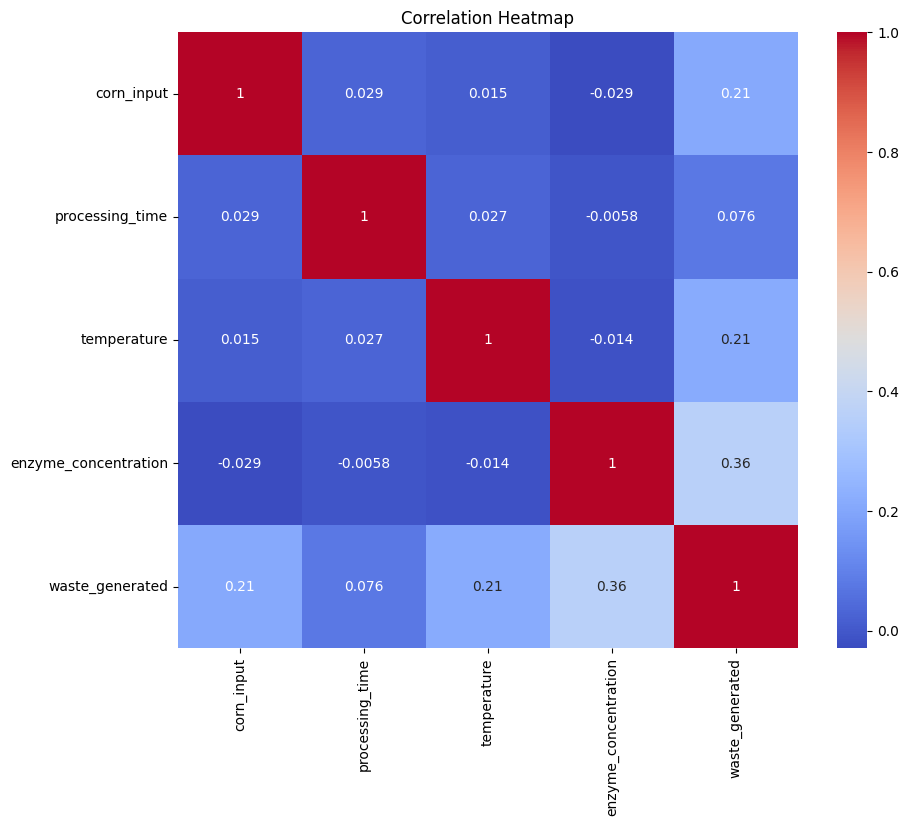

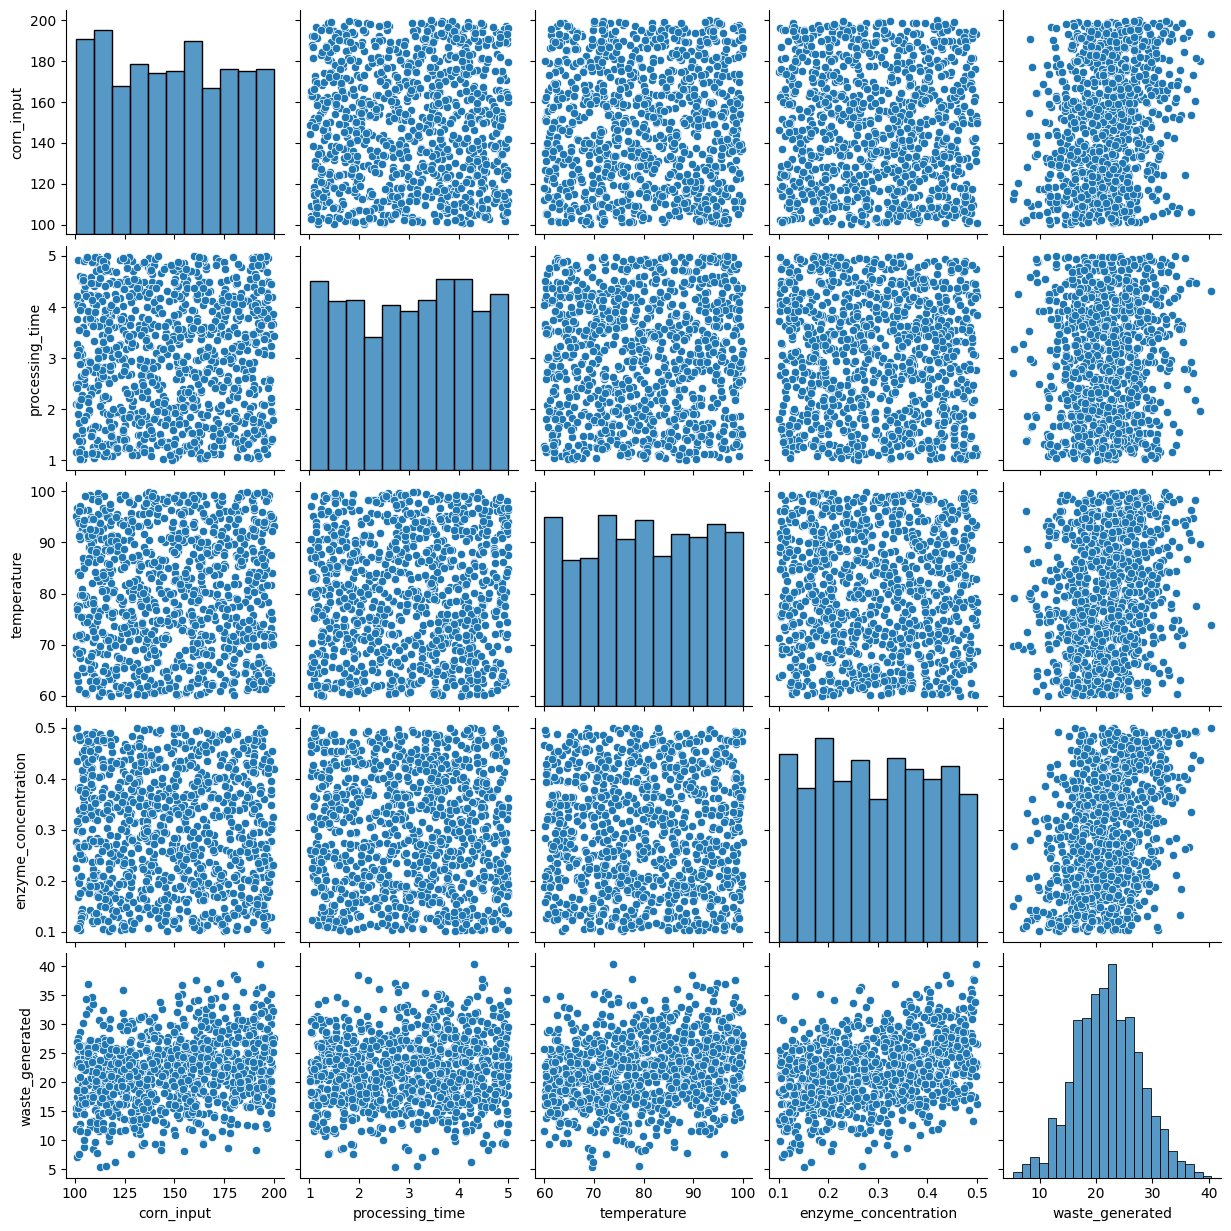

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to show correlation between variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot to visualize pairwise relationships
sns.pairplot(df)
plt.show()


## Step 4. Preprocessing Data
We will normalize the data, which is important for many machine learning algorithms.*

In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

df_scaled.head(11)


,corn_input,processing_time,temperature,enzyme_concentration,waste_generated
0,-0.396301,-1.102179,-0.828489,0.636740,1.089515
1,1.576957,0.119447,-0.879179,1.069707,0.920809
2,0.827893,1.252992,1.390047,-0.837822,-0.314165
3,0.371251,0.771143,-0.870342,0.469708,0.531228
4,-1.144685,1.025681,-0.793229,0.284170,-0.687240
5,-1.144767,0.519669,0.884568,1.195949,-0.214181
6,-1.480089,0.634354,-0.181276,1.451782,-0.803078
7,1.287434,1.171668,0.944157,-1.670071,-1.607712
8,0.379664,-0.881201,-1.504290,0.641339,-0.321972
9,0.745968,-0.060239,-0.051060,-1.531501,-0.291299


## Step 5. Implementing Reinforcement Learning Algorithm
#### Training the Reinforcement Learning Model
We will use a simple reinforcement learning model for this demonstration, focusing on predicting and minimizing waste generation.

In [26]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import Env
from gym.spaces import Box
import numpy as np
import pandas as pd

# Define the environment
class BiofuelEnv(Env):
    def __init__(self, data):
        super(BiofuelEnv, self).__init__()
        self.data = data
        self.action_space = Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        # Ensure reset returns a 2D array (batch dimension)
        return self.data.iloc[self.current_step, :-1].values.astype(np.float32).reshape(1, -1)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0
        
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32).reshape(1, -1)
        obs_flat = obs.flatten()  # Flatten observation to 1D for dot product
        waste_pred = np.dot(obs_flat, action)  # Simplified waste prediction
        reward = -abs(waste_pred - self.data.iloc[self.current_step, -1])  # Reward based on accuracy
        done = self.current_step == len(self.data) - 1
        
        return obs, reward, done, {}

# Assuming df_scaled is already defined and is a DataFrame
env = DummyVecEnv([lambda: BiofuelEnv(df_scaled)])

# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=20000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1514 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1094        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005911557 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.66       |
|    explained_variance   | -0.0053     |
|    learning_rate        | 0.0003      |
|    loss                 | 139         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00555    |
|    std                  | 0.992       |
|    value_loss           | 445         |
-----------------

#### Aggregate Performance Metrics
Instead of using direct comparisons of predicted vs. actual values, Evaluation of the model's performance were done using aggregated metrics over multiple episodes.

metrics include:

Total Reward: The sum of rewards received over an episode. This helps assess how well the model maximizes reward over time.

Average Reward per Episode: Average reward over a number of episodes to smooth out variations.

Episode Length: Average length of episodes, which can indicate how effectively the model is managing the environment.

In [28]:
def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    
    print(f"Mean Reward: {mean_reward}")
    print(f"Standard Deviation of Reward: {std_reward}")

evaluate_model(env, model)


Mean Reward: -1301.31396484375
Standard Deviation of Reward: 30.875730514526367


#### Visualize Actions and Rewards
You can visualize how the actions and rewards change over time during evaluation. This provides insight into how the model's behavior evolves and helps identify if it is learning effectively.

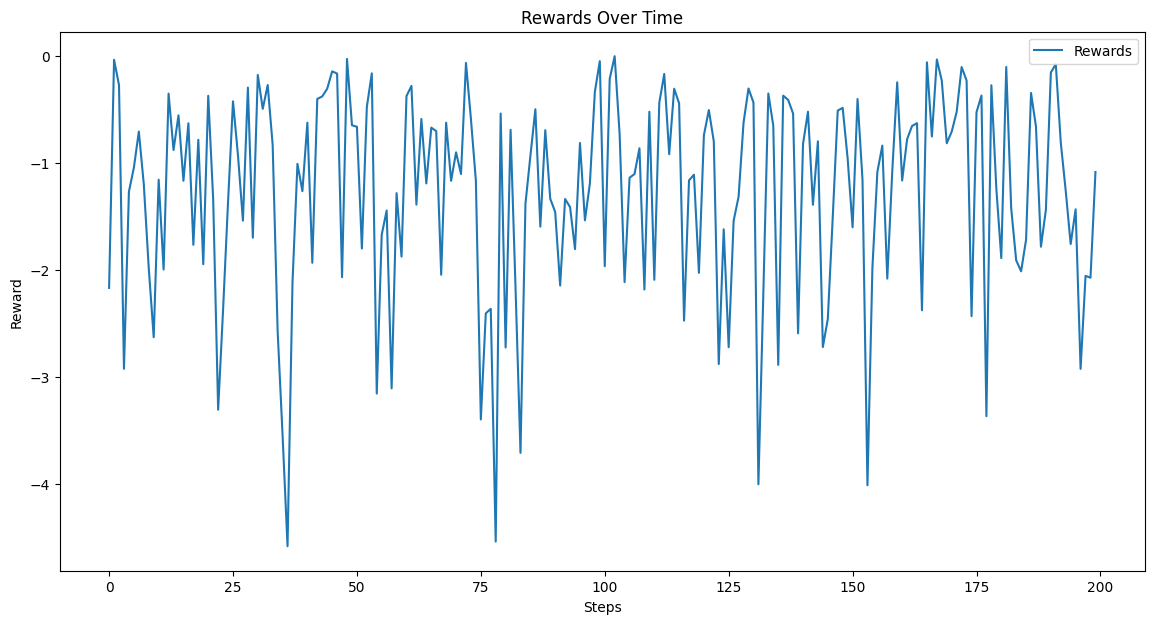

In [29]:
import matplotlib.pyplot as plt

def visualize_evaluation(env, model, num_steps=200):
    obs = env.reset()
    actions = []
    rewards = []

    for _ in range(num_steps):
        action, _states = model.predict(obs)
        actions.append(action)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            obs = env.reset()
    
    plt.figure(figsize=(14, 7))
    plt.plot(rewards, label="Rewards")
    plt.title("Rewards Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

visualize_evaluation(env, model)


#### Compare Model Performance Against a Baseline
Compare the performance of the trained model against a simple baseline model or a heuristic-based approach. This can give context to how well the reinforcement learning model is performing relative to a known standard.

#### Ensure Action Shape Compatibility

In [31]:
def baseline_policy(obs):
   
    obs = obs.flatten()
  

    action = np.zeros_like(obs)
    return action


####  Ensure Action Space Compatibility

In [32]:
def baseline_policy(obs):
    # Example: always choose the action with the value 0
    return np.zeros_like(obs)


#### Handle Action Shaping

In [33]:
def baseline_policy(obs):
    # Generate action with correct shape
    return np.zeros((env.num_envs, env.action_space.shape[0]), dtype=np.float32)


#### Evaluation Function

In [34]:
def evaluate_baseline(env, model, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Flatten observation if needed
            action = baseline_policy(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    
    print(f"Baseline Mean Reward: {mean_reward}")
    print(f"Baseline Standard Deviation of Reward: {std_reward}")

evaluate_baseline(env, model)


Baseline Mean Reward: -797.1768188476562
Baseline Standard Deviation of Reward: 0.0001220703125
